**22.05.10 by Min**

Basic Characteristics of Speech Signal Analysis

Time-Domain Signal Features - Energy, Zero Crossing, Pitch detection

Frequency-Domain Signal Features - Spectral Centroid, Spectral Flux

Other Speech Signal Characteristics - Pitch and Intonation
http://www.internationaljournalcorner.com/index.php/ijird_ojs/article/view/136185/95308

**Time-Domain Signal Features**

In [2]:
!pip install pydub

In [4]:
!pip install noisereduce

In [23]:
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio, IFrame, display
import numpy as np
from pydub import AudioSegment, effects
import statsmodels.api as sm
from noisereduce.noisereducev1 import reduce_noise
from scipy.signal import find_peaks
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
sr = 16000
file = '/content/drive/MyDrive/Colab Notebooks/myvoice.wav'
x,sr = librosa.load(file, mono=True, sr=sr)

In [9]:
print('sr = ', sr)
print('x shape = ', x.shape)
print('Audio length = ',librosa.get_duration(x, sr))

sr =  16000
x shape =  (80000,)
Audio length =  5.0


In [10]:
display(Audio(x,rate=sr))

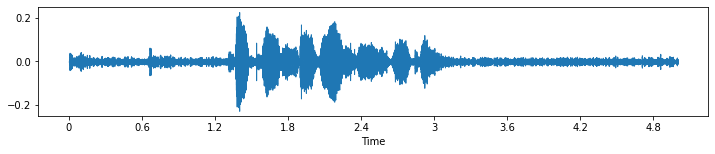

In [11]:
plt.figure(figsize=(12,2))
librosa.display.waveshow(x,sr=sr, x_axis='time');

In [191]:
reduced_x = reduce_noise(audio_clip=x, 
                          noise_clip=x, 
                          verbose=False)

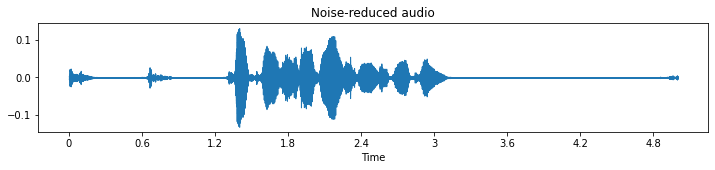

In [192]:
plt.figure(figsize=(12,2))
librosa.display.waveshow(reduced_x, sr)
plt.title('Noise-reduced audio')

ipd.display(ipd.Audio(data = reduced_x, rate=sr))

**Time-Domain Signal Features**

**Energy and RMSE**

The **energy** of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The energy in a signal is defined as

$$ \sum_n \left| x(n) \right|^2 $$

The **root-mean-square energy (RMSE)** in a signal is defined as

$$ \sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 } $$

In [98]:
hop_length = 256
frame_length = 512

In [109]:
energy = numpy.array([
    sum(abs(reduced_x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

In [110]:
energy.shape

(313,)

In [107]:
rmse = librosa.feature.rms(reduced_x, frame_length=frame_length, hop_length=hop_length, center=True)

In [108]:
rmse.shape

(1, 313)

In [111]:
rmse = rmse[0]

In [112]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

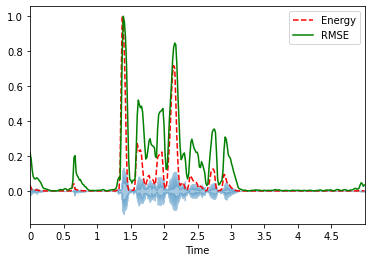

In [113]:
librosa.display.waveplot(reduced_x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))

**Zero Crossing Rate**-The zero crossing rate indicates the number of times that a signal crosses the horizontal axis.

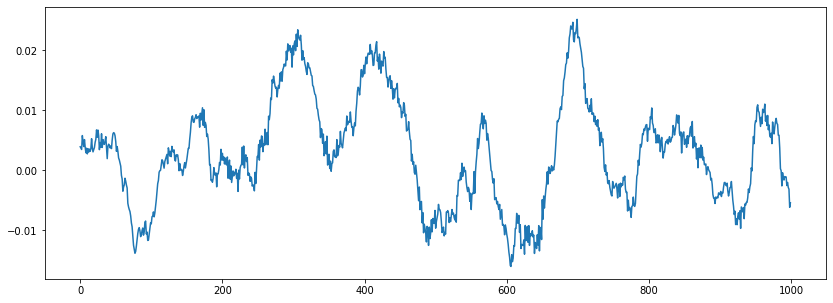

In [33]:
n0 = 7000
n1 = 8000
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])

In [114]:
zero_crossings = librosa.zero_crossings(reduced_x[n0:n1], pad=False)

In [115]:
zero_crossings.shape

(1000,)

In [116]:
print(sum(zero_crossings))

1


In [117]:
zcrs = librosa.feature.zero_crossing_rate(reduced_x)
print(zcrs.shape)

(1, 157)


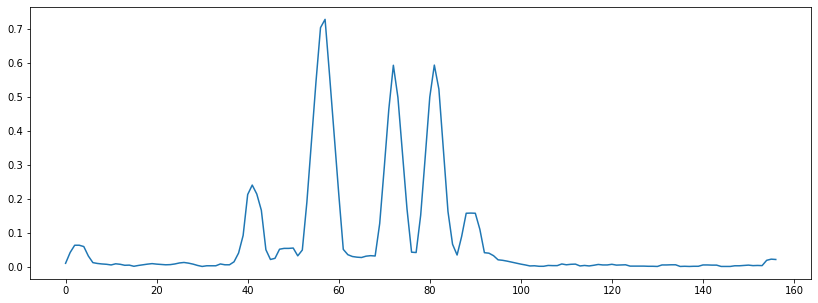

In [118]:
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

(-0.0001, 0.0001)

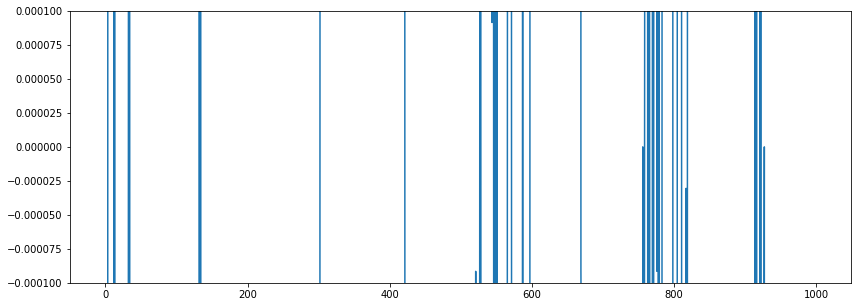

In [119]:
plt.figure(figsize=(14, 5))
plt.plot(x[:1000])
plt.ylim(-0.0001, 0.0001)

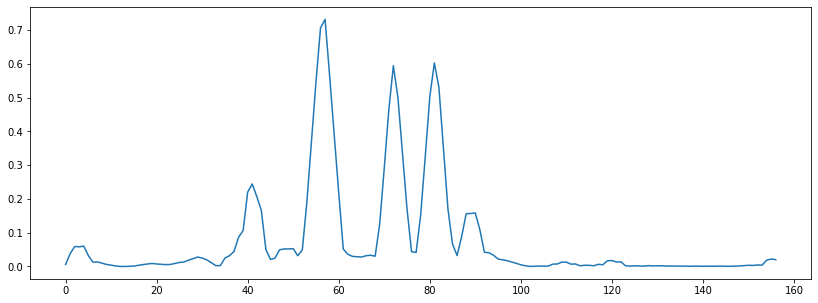

In [120]:
zcrs = librosa.feature.zero_crossing_rate(reduced_x + 0.0001)
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

**Pitch detection**-Identify the pitch of each note and replace each note with a pure tone of that pitch.

Display the CQT of the signal.

In [121]:
bins_per_octave = 36
cqt = librosa.cqt(reduced_x, sr=sr, n_bins=200, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(cqt)

In [122]:
cqt.shape

(200, 157)

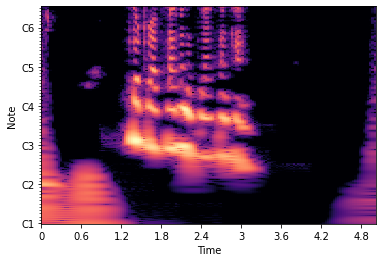

In [123]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave)

Step 1: Detect Onsets

In [164]:
hop_length = 100
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

(0.0, 801.0)

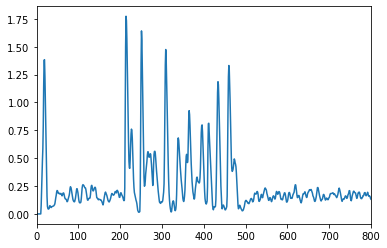

In [165]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

In [166]:
onset_samples = librosa.onset.onset_detect(x,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

In [167]:
onset_samples

array([ 1900, 21400, 25100, 30900, 36500, 41200, 43400, 46000])

In [168]:
onset_boundaries = numpy.concatenate([[0], onset_samples, [len(x)]])

In [169]:
print(onset_boundaries)

[    0  1900 21400 25100 30900 36500 41200 43400 46000 80000]


In [170]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)

In [171]:
onset_times

array([0.     , 0.11875, 1.3375 , 1.56875, 1.93125, 2.28125, 2.575  ,
       2.7125 , 2.875  , 5.     ])

Display the results of the onset detection:

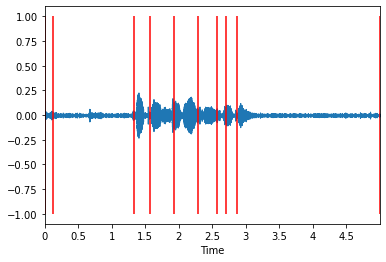

In [172]:
librosa.display.waveplot(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

Step 2: Estimate Pitch

In [173]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=1000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

Step 3: Generate Pure Tone

In [174]:
def generate_sine(f0, sr, n_duration):
    n = numpy.arange(n_duration)
    return 0.2*numpy.sin(2*numpy.pi*f0*n/float(sr))

Step 4: Put it together

In [175]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [184]:
y = numpy.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [185]:
ipd.Audio(y, rate=sr)

In [186]:
cqt = librosa.cqt(y, sr=sr)

Plot the CQT of the synthesized transcription

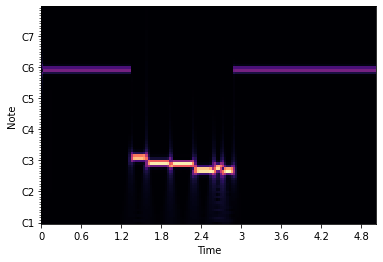

In [187]:
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')

**Frequency-Domain Signal Features**

**Spectral Features**- spectral moments (centroid, bandwidth, skewness, kurtosis) and other spectral statistics.


**Spectral Centroid**-The spectral centroid indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

fc=∑kS(k)f(k)/∑kS(k) 

where  S(k)  is the spectral magnitude at frequency bin  k ,  f(k)  is the frequency at bin  k .

librosa.feature.spectral_centroid computes the spectral centroid for each frame in a signal:

In [193]:
spectral_centroids = librosa.feature.spectral_centroid(reduced_x, sr=sr)[0]
spectral_centroids.shape

(157,)

In [194]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

In [195]:
def normalize(reduced_x, axis=0):
    return sklearn.preprocessing.minmax_scale(reduced_x, axis=axis)

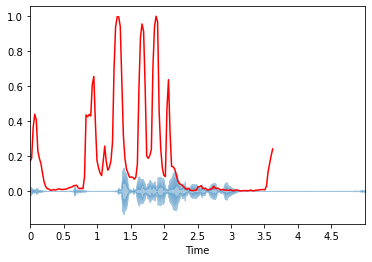

In [196]:
librosa.display.waveplot(reduced_x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

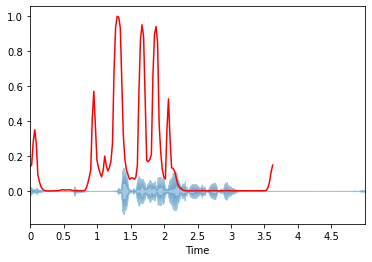

In [197]:
spectral_centroids = librosa.feature.spectral_centroid(reduced_x+0.01, sr=sr)[0]
librosa.display.waveplot(reduced_x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

**Spectral Bandwidth**

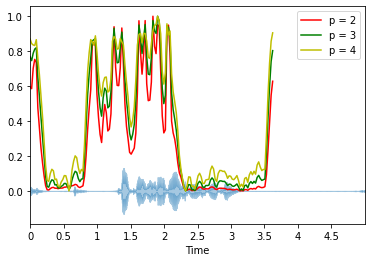

In [198]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(reduced_x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(reduced_x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(reduced_x+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(reduced_x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

**Spectral Contrast**-Spectral contrast considers the spectral peak, the spectral valley, and their difference in each frequency subband. For more information:

In [199]:
spectral_contrast = librosa.feature.spectral_contrast(reduced_x, sr=sr)
spectral_contrast.shape

(7, 157)

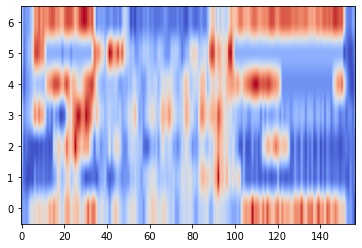

In [200]:
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')

**Spectral Rolloff**-Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

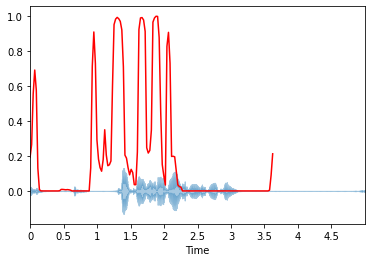

In [201]:
spectral_rolloff = librosa.feature.spectral_rolloff(reduced_x+0.01, sr=sr)[0]
librosa.display.waveplot(reduced_x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')